#### Import Relevant Python Packages

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='calibri')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    sns.despine()
    
# Single Column Plot (as per NRC CJCE specs)
def set_size_onecol(fig):
    fig.set_size_inches(9.3, 3.4)
def set_size_twocol(fig):
    fig.set_size_inches(9.3, 7.2)
#plt.rcParams['grid.color'] = 'k'
#plt.rcParams['grid.linestyle'] = ':'
#plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 'large'
#plt.rcParams["text.usetex"] = True
#plt.rcParams.keys()

# LTB of "Made-Up" Singly-Symmetric I-Sections
## Data Input
### Notes on the Data

Load section properties for **standard** W shapes. Properties loaded include width and thickness of compression and tension flanges,    
thickness of web, and overall height of beam.

It should be noted that the compression flange is assumed to be the top flange and the centriod of a cross-section is measured from the centriod of the top flange.

All section properties are reported in millimetres (mm). Datum shall be top of the cross-section.

### Input desired filename

In [2]:
# IF WINDOW: 'C:/jk/UofA/Courses/project_DRA/analysis/CISC_StructuralSectionTables/CISC_SST_ver92_W-cleaned.csv'
filename = 'c:/jk/UofA/Courses/project_DRA/analysis/CISC_StructuralSectionTables/CISC_SST_ver92_W-cleaned.csv'
(path,file) = os.path.split(filename)

In [3]:
df_orig = pd.read_csv(filename)

In [4]:
df_orig.rename(columns={'B': 'B1'}, inplace=True)
idx = df_orig.columns.get_loc('B1') + 1
df_orig.insert(loc=idx, column='B2', value=df_orig['B1'])
df = df_orig

## Create "Made-Up" Singly-Symmetric W-Shapes

Standard **doubly-symmetric** W-shape flange widths are adjusted to create a set of singly-symmetric variations of these shapes. It was chosen such that either the top or bottom flange is reduced to zero width while the opposite flange remains constant at the standard W-shape flange width.


Furthermore, flange widths are reduced in 10mm increments until zero flange width (i.e. T-beam cross-section).

In [5]:
t0 = time.time()

# CREATE LONGER COMPRESSION FLANGE SINGLY-SYMMETRIC W-SHAPES
dfcompression = pd.DataFrame()
for index, row in df.iterrows():
    Wshape = row['Dsg']
    no, rem = divmod(row['B2'],10)
    chk = rem != 0
    if chk is True:
        no = no + 1
    for i in range(int(no)):
        if row['B2'] > 10:
            row['B2'] = row['B2'] - 10
        else:
            row['B2'] = 0
        dfcompression = dfcompression.append(row)
dfcompression = dfcompression[df.columns]

t1 = time.time()
total = t1-t0
print(total)

89.37940454483032


In [6]:
t0 = time.time()

# CREATE LONGER TENSION FLANGE SINGLY-SYMMETRIC W-SHAPES
dftension = pd.DataFrame()
for index, row in df.iterrows():
    Wshape = row['Dsg']#; print(Wshape)
    no, rem = divmod(row['B1'],10)
    chk = rem != 0
    if chk is True:
        no = no + 1
    for i in range(int(no)):
        if row['B1'] > 10:
            row['B1'] = row['B1'] - 10
        else:
            row['B1'] = 0
        dftension = dftension.append(row)
dftension = dftension[df.columns]

t1 = time.time()
total = t1-t0
print(total)

86.77853107452393


### Create dataframe of "made-up" singly-symmetric I-sections.

*Does NOT include doubly-symmetric I-sections. These are contained in the original dataframe loaded from the input csvfile.*

In [7]:
frames = [dfcompression, dftension]
dfall_orig = pd.concat(frames).reset_index(drop=True)
dfall_orig['ID'] = dfall_orig.index

In [8]:
Fy = 350 #MPa

## Additional Section Property Calculatons

In [9]:
dfall = dfall_orig.copy()

*!!!ASSUMING THAT THE DATUM IS THE CENTROID OF THE TOP FLANGE!!!*

Determine the distance between flange centroids.

In [10]:
dfall['d_prime'] = dfall['D'] - dfall['T']
# Specifiy difference in d_prime calculation for Tees
dfall['d_prime'] = np.where(dfall_orig['B1'] == 0, dfall['D'] - dfall_orig['T']/2, dfall['d_prime'])
dfall['d_prime'] = np.where(dfall_orig['B2'] == 0, dfall['D'] - dfall_orig['T']/2, dfall['d_prime'])

### Determine the centroid of the singly-symmetric I-section.

Note: Datum shall be centroid of the top flange of the cross-section.

$\bar{y} = \frac{\Sigma y_i A_i}{\Sigma A_i}$

In [11]:
# Top Flange
y1 = 0
A1 = dfall['B1']*dfall['T']
# Bottom Flange
y2 = dfall['d_prime']
A2 = dfall['B2']*dfall['T']
# Web
y3 = dfall['d_prime']/2
A3 = dfall['W']*(dfall['d_prime'] - dfall['T'])

In [12]:
dfall['A'] = A1 + A2 + A3
dfall['y*A'] = y1*A1 + y2*A2 + y3*A3
dfall['y_bar_1'] = dfall['y*A']/dfall['A']
dfall['y_bar_2'] = dfall['d_prime'] - dfall['y_bar_1'] # IS THIS CORRECT????

### Determine the moment of inertia of "made-up" singly-symmetric I-sections

The moment of inertia of a rectangular section is $I_{rectangle} = \frac{bh^3}{12}$.

Furthermore, the **parallel axis theorem** is used to add the contribution of the flanges to the built-up beam cross-section. The **parallel axis theorem** is expressed as:

$I = \frac{bh^3}{12} + A(dx)^2$ 

where, the distance, $dx$, from the centriod of each flange to the cross-section centroid.

#### Determine the moment of inertia about the X-X axis, $I_x$

In [13]:
dfall['Ix_Flange1'] = (dfall['B1']*dfall['T']**3)/12 + A1*dfall['y_bar_1']**2
dfall['Ix_Flange2'] = (dfall['B2']*dfall['T']**3)/12 + A2*(dfall['y_bar_2'])**2
dfall['Ix_Web'] = (dfall['W']*(dfall['d_prime'] - dfall['T'])**3)/12 + A3*(dfall['d_prime']/2 - dfall['y_bar_1'])**2
dfall['Ix'] = dfall['Ix_Flange1'] + dfall['Ix_Web'] + dfall['Ix_Flange2']

#### Determine the moment of inertia about the Y-Y axis, $I_y$

In [14]:
dfall['Iy_Flange1'] = ((dfall['B1']**3)*dfall['T'])/12
dfall['Iy_Flange2'] = ((dfall['B2']**3)*dfall['T'])/12
dfall['Iy_Web'] = ((dfall['W']**3)*(dfall['d_prime'] - dfall['T']))/12
dfall['Iy'] = dfall['Iy_Flange1'] + dfall['Iy_Web'] + dfall['Iy_Flange2']

### Determine the Ratio of Major to Minor Moments of Inertia, $\frac{I_y}{I_x}$

In [15]:
dfall['Iy/Ix'] = dfall['Iy']/dfall['Ix']
dfall['W/4'] = dfall['W']/4

### Determine the Shear Centre, $y_o$

Determine the shear centre by two methods. *Method 2* is according to Kitipornchai and Trahair (1979); however, it is equivalent to the method (*Method 1*) presented in Galambo 1968 (see p. 2 of Singly-Symmetric Beams Notes).

**Method 1**

$\alpha = \frac{1}{1 + \frac{B1}{B2} \frac{T1}{T2}}$

$y_o = - |y_{bar}| + \alpha d^{\prime}$

**Method 2**

Mono-Symmetry factor, $\rho$, is calculated according to *Kitipornchai & Trahair (1979) Buckling Properties of Mono-Symmetric I-Beams*.

$\rho = \frac{I_{yc}}{I_{yc} + I_{yt}}$

The shear centre of a singly-symmetric beam can be calculated as follows:

$a = (1 - \rho)h^{\prime}$

$y_o = a - \bar{y}$

In [16]:
# Method 1: Galambos 1968
dfall['alpha'] = 1/(1 + (dfall['B1']/dfall['B2'])**3*(dfall['T']/dfall['T']))
dfall['Yo'] = -1*np.absolute(dfall['y_bar_1']) + dfall['alpha']*dfall['d_prime']

In [17]:
# Method 2: (Kitipornchai & Trahair 1979)
dfall[r'$\rho$'] = dfall['Iy_Flange1']/(dfall['Iy_Flange1'] + dfall['Iy_Flange2'])
dfall['Yo_alternate'] = (1 - dfall[r'$\rho$'])*dfall['d_prime'] - dfall['y_bar_1']

### Torsional Parameters -> St. Venant & Warping Torsion

Some additional section properties that are computed based on equations in Galambo 1968 such as the St. Venant and warping torsional constants.

In [18]:
dfall['J'] = (1/3)*(dfall['B1']*dfall['T']**3 + (dfall['d_prime'] - dfall['T'])*dfall['W']**3 + dfall['B2']*dfall['T']**3)
dfall['Cw'] = (dfall['d_prime']**2)*dfall['Iy_Flange1']*dfall['alpha']

## Section Classification

Section classification based on flange and web local buckling checks.
Assuming a 350W Grade for steel, $F_y = 350MPa$.

In [19]:
t0 = time.time()

# Initialize new dataframe to contain Section Class
dfallnew = pd.DataFrame()
# Determine Mono-symmetric I-section Web Local Buckling Requirements
sqrtFy = np.sqrt(Fy)
# Set up S16 code requirements for flanges
crit1 = 145
crit2 = 170
crit3 = 200
# requirement for T-section stems
crit4stems = 340
# requirement for Webs of monosymmetric I-sections
crit1w = 1100
crit2w = 1700
crit3w = 1900
# Determine Web Class
for index,row in dfall.iterrows():
    #########################################################################################################
    # Determine Section Class of rho = 0: Stems of T-sections
    if row[r'$\rho$'] == 0:
        # T-section stem tip criteria
        row['T-Section Stem Criteria'] = (row['D']/row['W'])*sqrtFy
        # Determine T-section stem tip Class
        # For the purpose of the code place this class into the same column as for the compression flange class calculation
        row['Section Class'] = np.where(row['T-Section Stem Criteria'] < crit1, 1, np.where(row['T-Section Stem Criteria'] < crit2, 2, np.where(row['T-Section Stem Criteria'] < crit4stems, 3, 4)))
    
    #########################################################################################################
    # Determine Section Class of rho = 1: Flange of T-section
    elif row[r'$\rho$'] == 1:
        # Compression Flange Criteria
        row['Flange Criteria'] = ((row['B1']/2)/row['T'])*sqrtFy
        # Determine Flange Class
        row['Section Class'] = np.where(row['Flange Criteria'] < crit1, 1, np.where(row['Flange Criteria'] < crit2, 2, np.where(row['Flange Criteria'] < crit3, 3, 4)))
    
    #########################################################################################################
    # Determine Section Class of all of the Monosymmetric Sections 
    else:
        # Compression Flange Criteria
        row['Flange Criteria'] = ((row['B1']/2)/row['T'])*sqrtFy
        # Determine Flange Class
        row['Flange Class'] = np.where(row['Flange Criteria'] < crit1, 1, np.where(row['Flange Criteria'] < crit2, 2, np.where(row['Flange Criteria'] < crit3, 3, 4)))
        #####################################################################################################
        # Determine Class of Web
        if row['Flange Class'] >= 3:
            # Use ENA for web class check regardless
            row['dc'] = row['y_bar_1'] - row['T']/2
            row['Web Criteria'] = ((2*row['dc'])/row['W'])*sqrtFy
            row['Web Class'] = np.where(row['Web Criteria'] < crit1w, 1, np.where(row['Web Criteria'] < crit2w, 2, np.where(row['Web Criteria'] < crit3w, 3, 4)))
        else:
            #################################################################################################
            # Assume PNA for web class check
            row['dc'] = ((row['d_prime'] - row['T'])/2) - (((row['B1'] - row['B2'])*row['T'])/(2*row['W']))
            row['Web Criteria'] = ((2*row['dc'])/row['W'])*sqrtFy
            row['Web Class'] = np.where(row['Web Criteria'] < crit1w, 1, np.where(row['Web Criteria'] < crit2w, 2, np.where(row['Web Criteria'] < crit3w, 3, 4)))
            # If web class is 3 or 4, recalculate using ENA
            if (row['Web Class'] == 3 | row['Web Class'] == 4):
                row['dc'] = row['y_bar_1'] - row['T']/2
                web_criteria = (2*row['dc'])/row['W']
                row['Web Class'] = np.where(row['Web Criteria'] < crit1w, 1, np.where(row['Web Criteria'] < crit2w, 2, np.where(row['Web Criteria'] < crit3w, 3, 4)))
        
        if row['dc'] < 0:
            row['dc'] = 0
            row['Section Class'] = row['Flange Class']
        else:
            row['Section Class'] = max(row['Flange Class'], row['Web Class'])
                                                           
    # Append to new dataframe
    dfallnew = dfallnew.append(row)
    
t1 = time.time()
total = t1-t0
print(total)

338.50125098228455


### Determine the Asymmetry Parameter, $\beta_x$

Determine $\beta_x$ from true expression and from approximate formula given in S16-14. Note that the true $\beta_x$ is calculated in two steps where the flange contributions are determined first and then combined to achieve the true value.

$\beta_{x}$ will be calculated based on the true integral expression and various approximations.

The integral (true) expression for $\beta_{x}$ is calculated by:

$\beta_{x} = \frac{1}{I_{x}} (\int_{A}{x^{2}ydA} + \int_{A}{y^{3}dA}) - 2y_{o}$

Which can be further simplified to the following as per *Galambos (1968)*.

$\beta_{x} = \frac{1}{I_x} ((h-\bar{y})(\frac{b_t^3 t_t}{12} + b_t t_t (h-\bar{y})^2 + (h-\bar{y})^3 \frac{w}{4}) - \bar{y}(\frac{b_c^3 t_t}{12} + b_c t_c \bar{y}^2 + \bar{y}^3 \frac{w}{4})) - 2y_o$

Approximation for $\beta_{x}$ is from *Kitipornchai & Trahair (1979) Buckling Properties of Monosymmetric I-Beams* and is calculated by:

$\beta_{x} = 0.9h(2\rho - 1)(1 - (\frac{I_y}{I_x})^{2})$, where $\rho = \frac{I_{yc}}{I_{yc} + I_{yt}}$

Furthermore, $\beta_{x}$ is calculated according to the CSA S16-14 standard which is computed by:

$\beta_{x} = 0.9(d-t)(\frac{2I_{yc}}{I_{y}} - 1)(1 - (\frac{I_{y}}{I_{x}})^{2})$

In [20]:
dfallnew['Flange1_Contribution'] = dfallnew['y_bar_1']*(dfallnew['Iy_Flange1'] + A1*dfallnew['y_bar_1']**2 + dfallnew['W/4']*dfallnew['y_bar_1']**3)
dfallnew['Flange2_Contribution'] = dfallnew['y_bar_2']*(dfallnew['Iy_Flange2'] + A2*dfallnew['y_bar_2']**2 + dfallnew['W/4']*dfallnew['y_bar_2']**3)

In [21]:
dfallnew['BetX_calc'] = ((dfallnew['Flange2_Contribution'] - dfallnew['Flange1_Contribution'])/dfallnew['Ix'] - 2*dfallnew['Yo'])
dfallnew['BetX_K&T'] = (0.9*dfallnew['d_prime']*(2*dfallnew[r'$\rho$'] - 1)*(1 - (dfallnew['Iy']/dfallnew['Ix'])**2))
dfallnew['BetX_S16-14'] = (0.9*dfallnew['d_prime']*(((2*dfallnew['Iy_Flange1'])/dfallnew['Iy']) - 1)*(1 - (dfallnew['Iy']/dfallnew['Ix'])**2))

## Determine % Error Between True $\beta_x$ and Approximated $\beta_x$

In [22]:
dfallnew['Percent Error K&T'] = ((dfallnew['BetX_K&T'] - dfallnew['BetX_calc'])/np.absolute(dfallnew['BetX_calc']))*100
dfallnew['Percent Error S16-14'] = ((dfallnew['BetX_S16-14'] - dfallnew['BetX_calc'])/np.absolute(dfallnew['BetX_calc']))*100

In [23]:
dfallnew.to_csv('madeupsinglysymmetric_properties.csv')

In [ ]:
### Percent Error Statistics

In [ ]:
data = dfallnew.copy()
group1 = data[(data[r'$\rho$'] < 0.1)]
group2 = data[(data[r'$\rho$'] > 0.1) & (data[r'$\rho$'] < 0.5)]
group3 = data[(data[r'$\rho$'] > 0.5) & (data[r'$\rho$'] < 0.9)]
group4 = data[(data[r'$\rho$'] > 0.9)]

In [ ]:
m1a = np.mean(group1['Percent Error K&T'])
s1a = np.std(group1['Percent Error K&T'])
m2a = np.mean(group2['Percent Error K&T'])
s2a = np.std(group2['Percent Error K&T'])
m3a = np.mean(group3['Percent Error K&T'])
s3a = np.std(group3['Percent Error K&T'])
m4a = np.mean(group4['Percent Error K&T'])
s4a = np.std(group4['Percent Error K&T'])

In [ ]:
### Percent Error Statistics

data = dfallnew.copy()
group1 = data[(data[r'$\rho$'] < 0.1)]
group2 = data[(data[r'$\rho$'] > 0.1) & (data[r'$\rho$'] < 0.5)]
group3 = data[(data[r'$\rho$'] > 0.5) & (data[r'$\rho$'] < 0.9)]
group4 = data[(data[r'$\rho$'] > 0.9)]

m1a = np.mean(group1['Percent Error K&T'])
s1a = np.std(group1['Percent Error K&T'])
m2a = np.mean(group2['Percent Error K&T'])
s2a = np.std(group2['Percent Error K&T'])
m3a = np.mean(group3['Percent Error K&T'])
s3a = np.std(group3['Percent Error K&T'])
m4a = np.mean(group4['Percent Error K&T'])
s4a = np.std(group4['Percent Error K&T'])

m1b = np.mean(group1['Percent Error S16-14'])
s1b = np.std(group1['Percent Error S16-14'])
m2b = np.mean(group2['Percent Error S16-14'])
s2b = np.std(group2['Percent Error S16-14'])
m3b = np.mean(group3['Percent Error S16-14'])
s3b = np.std(group3['Percent Error S16-14'])
m4b = np.mean(group4['Percent Error S16-14'])
s4b = np.std(group4['Percent Error S16-14'])

print('Group 1: mean = %.2f and stdev = %.2f' %(m1a, s1a))
print('Group 2: mean = %.2f and stdev = %.2f' %(m2a, s2a))
print('Group 3: mean = %.2f and stdev = %.2f' %(m3a, s3a))
print('Group 4: mean = %.2f and stdev = %.2f' %(m4a, s4a))

print('Group 1: mean = %.2f and stdev = %.2f' %(m1b, s1b))
print('Group 2: mean = %.2f and stdev = %.2f' %(m2b, s2b))
print('Group 3: mean = %.2f and stdev = %.2f' %(m3b, s3b))
print('Group 4: mean = %.2f and stdev = %.2f' %(m4b, s4b))

x1a = np.max(group1['Percent Error K&T'])
n1a = np.min(group1['Percent Error K&T'])
x2a = np.max(group2['Percent Error K&T'])
n2a = np.min(group2['Percent Error K&T'])
x3a = np.max(group3['Percent Error K&T'])
n3a = np.min(group3['Percent Error K&T'])
x4a = np.max(group4['Percent Error K&T'])
n4a = np.min(group4['Percent Error K&T'])

x1b = np.max(group1['Percent Error S16-14'])
n1b = np.min(group1['Percent Error S16-14'])
x2b = np.max(group2['Percent Error S16-14'])
n2b = np.min(group2['Percent Error S16-14'])
x3b = np.max(group3['Percent Error S16-14'])
n3b = np.min(group3['Percent Error S16-14'])
x4b = np.max(group4['Percent Error S16-14'])
n4b = np.min(group4['Percent Error S16-14'])

print('Group 1: mean = %.2f and stdev = %.2f' %(x1a, n1a))
print('Group 2: mean = %.2f and stdev = %.2f' %(x2a, n2a))
print('Group 3: mean = %.2f and stdev = %.2f' %(x3a, n3a))
print('Group 4: mean = %.2f and stdev = %.2f' %(x4a, n4a))

print('Group 1: mean = %.2f and stdev = %.2f' %(x1b, n1b))
print('Group 2: mean = %.2f and stdev = %.2f' %(x2b, n2b))
print('Group 3: mean = %.2f and stdev = %.2f' %(x3b, n3b))
print('Group 4: mean = %.2f and stdev = %.2f' %(x4b, n4b))

In [1]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
output_notebook()

# prepare some data
x = dfallnew[r'$\rho$']
y = dfallnew['Percent Error K&T']

# create a new plot with a title and axis labels
p = figure(title="Evaluation of CSA S16-14 Asymmetry Parameter")

# add a line renderer with legend and line thickness
p.scatter(x, y)

# show the results
show(p)

Loading BokehJS ...

NameError: name 'dfallnew' is not defined

## Section Class Statistics

In [24]:
print('Number of Class 1, 2, 3 Sections: %d' % len(dfallnew[(dfallnew['Section Class'] < 4)]))
print('Number of Class 4 Sections: %d' % len(dfallnew[(dfallnew['Section Class'] == 4)]))
print('Percentage of Class 4 Sections: %.2f' % ((len(dfallnew[(dfallnew['Section Class'] == 4)])/len(dfallnew['Section Class']))*100))

Number of Class 1, 2, 3 Sections: 16018
Number of Class 4 Sections: 294
Percentage of Class 4 Sections: 1.80


In [25]:
c123r0 = len(dfallnew[(dfallnew[r'$\rho$'] == 0) & (dfallnew['Section Class'] < 4)])
print('Number of Class 1, 2, 3 Sections: %d' % c123r0)
c4r0 = len(dfallnew[(dfallnew[r'$\rho$'] == 0) & (dfallnew['Section Class'] == 4)])
print('Number of Class 4 Sections: %d' % c4r0)
c123r1 = len(dfallnew[(dfallnew[r'$\rho$'] == 1) & (dfallnew['Section Class'] < 4)])
print('Number of Class 1, 2, 3 Sections: %d' % c123r1)
c4r1 = len(dfallnew[(dfallnew[r'$\rho$'] == 1) & (dfallnew['Section Class'] == 4)])
print('Number of Class 4 Sections: %d' % c4r1)
print('Percentage of Class 4 Sections with respect to Class 1,2,3 Sections: %.2f' % (((c4r0 + c4r1)/(c123r0 + c123r1))*100))
print('Percentage of Class 4 Sections with respect to total number of sections: %.2f' % (((c4r0 + c4r1)/(c123r0 + c123r1 + c4r0 + c4r1))*100))

Number of Class 1, 2, 3 Sections: 38
Number of Class 4 Sections: 243
Number of Class 1, 2, 3 Sections: 278
Number of Class 4 Sections: 3
Percentage of Class 4 Sections with respect to Class 1,2,3 Sections: 77.85
Percentage of Class 4 Sections with respect to total number of sections: 43.77


In [26]:
print(max(dfallnew[(dfallnew[r'$\rho$'] >= 0.5) & (dfallnew[r'$\rho$'] <= 0.9)]['Percent Error K&T']))
print(max(dfallnew[(dfallnew[r'$\rho$'] >= 0.5) & (dfallnew[r'$\rho$'] <= 0.9)]['Percent Error S16-14']))

-2.5397154498754424
-2.982864296240508


## Plotting the % Error for All "Made-Up" Singly-Symmetric W-Shapes

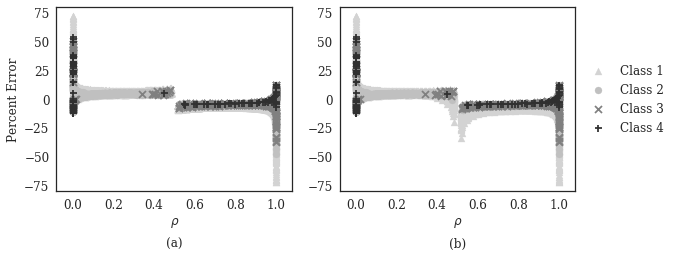

In [27]:
# Set Figure style
set_style()
# Compute Figure 2
fig2, ax2 = plt.subplots(nrows=1, ncols=2)
mkr_dict_def = {1: 'Class 1', 2: 'Class 2', 3: 'Class 3', 4: 'Class 4'}
mkr_dict = {1: '^', 2: 'o', 3: 'x', 4: '+'}
color = {1: '#D3D3D3', 2: '#C0C0C0', 3: '#808080', 4: '#303030'}
for kind in mkr_dict:
    dd = dfallnew[dfallnew['Section Class'] == kind]
    ax2[0].scatter(dd[r'$\rho$'], dd['Percent Error K&T'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax2[0].tick_params(axis='both', which='major', labelsize=12)
    ax2[1].scatter(dd[r'$\rho$'], dd['Percent Error S16-14'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax2[1].tick_params(axis='both', which='major', labelsize=12)
# Set the y-axis label only for the left subplot
ax2.flat[0].set_ylabel('Percent Error', fontsize='12')
ax2.flat[0].set_xlabel(r'$\rho$', fontsize='12')
ax2.flat[1].set_xlabel(r'$\rho$', fontsize='12')
# Set x and y limits
ax2.flat[0].set_ylim((-80,80))
ax2.flat[1].set_ylim((-80,80))
# And a corresponding grid
#ax2.flat[0].grid(which='both', c='k')
#ax2.flat[0].grid(which='major', alpha=0.2)
#ax2.flat[1].grid(which='both', c='k')
#ax2.flat[1].grid(which='major', alpha=0.2)
# Set the labels for each column
ax2.flat[0].text(0.5,-0.3, "(a)", size=12, ha="center", transform=ax2.flat[0].transAxes)
ax2.flat[1].text(0.5,-0.3, "(b)", size=12, ha="center", transform=ax2.flat[1].transAxes)
# Create Legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='12')
# Set size as per CJCE requirements
set_size_onecol(fig2)
# Save the figure
plt.savefig('./paper_figs/Figure2.png', bbox_inches="tight")
plt.savefig('./paper_figs/Figure2.pdf', bbox_inches="tight")
plt.savefig('./paper_figs/Figure2.svg', bbox_inches="tight")

### Plotting the % Error for "Made-Up" T-Sections

In [28]:
rho_0 = dfallnew[dfallnew[r'$\rho$'] == 0]
#print(max(rho_0['Percent Error K&T']))
rho_1 = dfallnew[dfallnew[r'$\rho$'] == 1]
#print(max(rho_1['Percent Error K&T']))

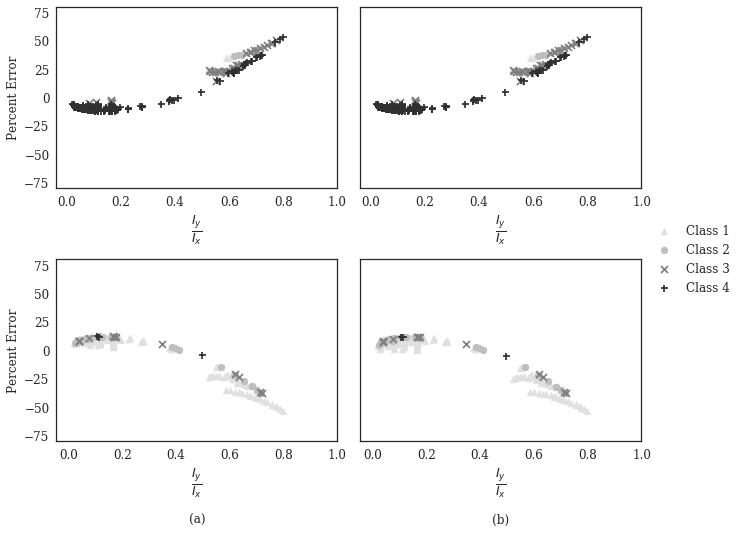

In [29]:
# Set Figure style
set_style()
# Compute Figure 3
fig3, ax3 = plt.subplots(nrows=2, ncols=2, sharey=True)
mkr_dict_def = {1: 'Class 1', 2: 'Class 2', 3: 'Class 3', 4: 'Class 4'}
mkr_dict = {1: '^', 2: 'o', 3: 'x', 4: '+'}
color = {1: '#E0E0E0', 2: '#BEBEBE', 3: '#808080', 4: '#303030'}
for kind in mkr_dict:
    rd0 = rho_0[rho_0['Section Class'] == kind]
    rd1 = rho_1[rho_1['Section Class'] == kind]
    ax3[0,0].scatter(rd0['Iy/Ix'], rd0['Percent Error K&T'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax3[0,0].tick_params(axis='both', which='major', labelsize=12)
    ax3[1,0].scatter(rd1['Iy/Ix'], rd1['Percent Error K&T'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax3[1,0].tick_params(axis='both', which='major', labelsize=12)
    ax3[0,1].scatter(rd0['Iy/Ix'], rd0['Percent Error S16-14'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax3[0,1].tick_params(axis='both', which='major', labelsize=12)
    ax3[1,1].scatter(rd1['Iy/Ix'], rd1['Percent Error S16-14'], color=color[kind], marker=mkr_dict[kind], label=mkr_dict_def[kind])
    ax3[1,1].tick_params(axis='both', which='major', labelsize=12)
# Set the x- and y-axis label only for the left and bottom
ax3.flat[0].set_ylabel('Percent Error', fontsize='12')
ax3.flat[2].set_ylabel('Percent Error', fontsize='12')
ax3.flat[0].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
ax3.flat[1].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
ax3.flat[2].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
ax3.flat[3].set_xlabel(r'$\frac{I_y}{I_x}$', fontsize='18')
# Set x and y limits
ax3.flat[0].set_ylim((-80,80))
ax3.flat[1].set_ylim((-80,80))
ax3.flat[0].set_xticks((0,0.2,0.4,0.6,0.8,1))
ax3.flat[1].set_xticks((0,0.2,0.4,0.6,0.8,1))
ax3.flat[2].set_xticks((0,0.2,0.4,0.6,0.8,1))
ax3.flat[3].set_xticks((0,0.2,0.4,0.6,0.8,1))
# Set the labels for each column
#ax3.flat[0].text(0.5,-0.325, "(a)", size=12, ha="center", transform=ax3.flat[0].transAxes)
#ax3.flat[1].text(0.5,-0.325, "(b)", size=12, ha="center", transform=ax3.flat[1].transAxes)
ax3.flat[2].text(0.5,-0.45, "(a)", size=12, ha="center", transform=ax3.flat[2].transAxes)
ax3.flat[3].text(0.5,-0.45, "(b)", size=12, ha="center", transform=ax3.flat[3].transAxes)
# Create Legend
plt.legend(loc='center left', bbox_to_anchor=(1, 1), fontsize='12')
# Set size as per CJCE requirements
set_size_twocol(fig3)
# Set up tight plot layout
plt.tight_layout()
# Save the figure
plt.savefig('./paper_figs/Figure3.png', bbox_inches="tight")
plt.savefig('./paper_figs/Figure3.pdf', bbox_inches="tight")
plt.savefig('./paper_figs/Figure3.svg', bbox_inches="tight")

In [30]:
W250x25 = dfallnew[dfallnew['Dsg'] == 'W250x25']
W360x592 = dfallnew[dfallnew['Dsg'] == 'W310x86']
W1100x499 = dfallnew[dfallnew['Dsg'] == 'W360x463']

In [31]:
# Set Figure style
set_style()
# Compute Figure 5
fig5, ax5 = plt.subplots(nrows=1, ncols=3)
ax5[0].scatter(W1100x499[r'$\rho$'], W1100x499['BetX_calc'], color='#BEBEBE', marker='s', label='Exact')
ax5[0].scatter(W1100x499[r'$\rho$'], W1100x499['BetX_K&T'], color='None', edgecolor='#303030', linewidth='0.75', marker='o', label='K&T')
ax5[0].scatter(W1100x499[r'$\rho$'], W1100x499['BetX_S16-14'], color='#808080', marker='+', label='S16-14')
ax5[0].tick_params(axis='both', which='major', labelsize=12)
ax5[1].scatter(W360x592[r'$\rho$'], W360x592['BetX_calc'], color='#BEBEBE', marker='s', label='Exact')
ax5[1].scatter(W360x592[r'$\rho$'], W360x592['BetX_K&T'], color='None', edgecolor='#303030', linewidth='0.75', marker='o', label='K&T')
ax5[1].scatter(W360x592[r'$\rho$'], W360x592['BetX_S16-14'], color='#808080', marker='+', label='S16-14')
ax5[1].tick_params(axis='both', which='major', labelsize=12)
ax5[2].scatter(W250x25[r'$\rho$'], W250x25['BetX_calc'], color='#BEBEBE', marker='s', label='Exact')
ax5[2].scatter(W250x25[r'$\rho$'], W250x25['BetX_K&T'], color='None', edgecolor='#303030', linewidth='0.75', marker='o', label='K&T')
ax5[2].scatter(W250x25[r'$\rho$'], W250x25['BetX_S16-14'], color='#808080', marker='+', label='S16-14')
ax5[2].tick_params(axis='both', which='major', labelsize=12)
# Set the x- and y-axis label only for the left and bottom
ax5.flat[0].set_ylabel(r'Asymmetry Parameter, $\beta_x$ (mm)', fontsize='12')
ax5.flat[0].set_xlabel(r'$\rho$', fontsize='12')
ax5.flat[1].set_xlabel(r'$\rho$', fontsize='12')
ax5.flat[2].set_xlabel(r'$\rho$', fontsize='12')
# Set x and y limits
ax5.flat[0].set_ylim((-350,350))
ax5.flat[1].set_ylim((-300,300))
ax5.flat[2].set_ylim((-300,300))
ax5.flat[0].set_xticks((0,0.2,0.4,0.6,0.8,1))
ax5.flat[1].set_xticks((0,0.2,0.4,0.6,0.8,1))
ax5.flat[2].set_xticks((0,0.2,0.4,0.6,0.8,1))
# Set the labels for each column
ax5.flat[0].text(0.5,-0.3, "(a)", size=12, ha="center", transform=ax5.flat[0].transAxes)
ax5.flat[1].text(0.5,-0.3, "(b)", size=12, ha="center", transform=ax5.flat[1].transAxes)
ax5.flat[2].text(0.5,-0.3, "(c)", size=12, ha="center", transform=ax5.flat[2].transAxes)
# Create Legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Set size as per CJCE requirements
set_size_onecol(fig5)
# Set up tight plot layout
plt.tight_layout()
# Save the figure
plt.savefig('./paper_figs/Figure5.png', bbox_inches="tight")
plt.savefig('./paper_figs/Figure5.pdf', bbox_inches="tight")
plt.savefig('./paper_figs/Figure5.svg', bbox_inches="tight")

TypeError: Cannot cast array data from dtype('<U4') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('<U4') to dtype('float64') according to the rule 'safe'

## Elastic Critical Moment Capacity based on CSA S16-14

In [32]:
dfallwCapacity = pd.DataFrame()
E = 200000 #MPa
G = 77000 #MPa
L = 10000 #mm, Assuming a 10m long beam... discussion?
w2 = 1 #Assuming uniform bending (can generalize later...)
for index,row in dfallnew.iterrows():
    if row['BetX_calc'] >= 0:
        row['Mo_(cr)_exact'] = ((np.pi**2*E*row['Iy']*row['BetX_calc'])/(2*L**2))*(1 + np.sqrt(1 + (4/row['BetX_calc']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))
    else:
        row['Mo_(cr)_exact'] = ((np.pi**2*E*row['Iy']*row['BetX_calc'])/(2*L**2))*(1 - np.sqrt(1 + (4/row['BetX_calc']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))                
    if row['BetX_S16-14'] >= 0:
        row['Mo_(cr)_S16'] = ((np.pi**2*E*row['Iy']*row['BetX_S16-14'])/(2*L**2))*(1 + np.sqrt(1 + (4/row['BetX_S16-14']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))
    else:
        row['Mo_(cr)_S16'] = ((np.pi**2*E*row['Iy']*row['BetX_S16-14'])/(2*L**2))*(1 - np.sqrt(1 + (4/row['BetX_S16-14']**2)*((G*row['J']*L**2)/(np.pi**2*E*row['Iy']) + row['Cw']/row['Iy'])))
    # Append to new dataframe
    dfallwCapacity = dfallwCapacity.append(row)

In [33]:
dfallwCapacity['Percent Error of BetX Effect on Moment'] = ((dfallwCapacity['Mo_(cr)_S16'] - dfallwCapacity['Mo_(cr)_exact'])/np.absolute(dfallwCapacity['Mo_(cr)_exact']))*100

In [34]:
maxeffectonmoment = np.max(dfallwCapacity['Percent Error of BetX Effect on Moment'])
print(maxeffectonmoment)
meaneffectonmoment = np.mean(dfallwCapacity['Percent Error of BetX Effect on Moment'])
print(meaneffectonmoment)
stddeveffectonmoment = np.std(dfallwCapacity['Percent Error of BetX Effect on Moment'])
print(stddeveffectonmoment)

27.781915700555025
-0.1394607344631017
2.389030931250682


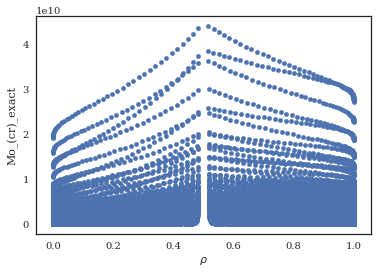

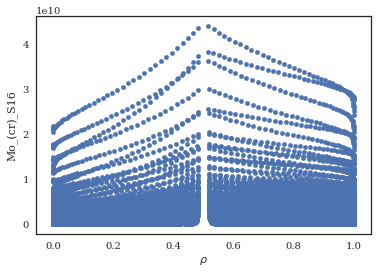

In [35]:
dfallwCapacity.plot(kind='scatter', x=r'$\rho$', y='Mo_(cr)_exact')
dfallwCapacity.plot(kind='scatter', x=r'$\rho$', y='Mo_(cr)_S16')

In [36]:
dfallwCapacity.to_csv('madeupsinglysymmetric_withMomentCapacity_properties.csv')

In [ ]:
# dfallwCapacity.plot(kind='scatter', x=r'$\rho$', y='Percent Error of BetX Effect on Moment')
# plt.savefig('./figs/AdditionalMomentEffect.pdf', bbox_inches="tight")